### As of 9/3/2019

Updated pivotal card: https://www.pivotaltracker.com/story/show/168254684

Updates:
- Updated states: AL, AR, CT, DE, GA (use total IA Spend), ME, NC, ND, NE, RI, SC, SD, UT, WA, WY, WV
- update current upstream spend to be overall IA spend
- update projected spend to include ISP cost projection
- include the following metrics from the draft:
    -xx million students on state networks can be quickly upgraded to the 1 Mbps per student goal
    -This will upgrade over ## million students and position the nation to connect 99% of our schools to the 1 Mbps per student goal by 202
- Chart #: State leadership can make digital learning a reality for ## million students by 2022
- [Insert 2 national heat maps showing where states are on 1 Mbps (% of districts or students) in 2019 and in 2022 if all of the above upgrades happen]


### Original: 

ideally, evan would review the material and give us the price projection he is comfortable with (he has been asking us for many pieces of analysis to lead to this question, including molly/surafael/jamies projections and now this one from adam). in the absence of his final 10G and 1G projection, i have recommended using \$ 2500 for 10G and \$ 890 for 1G.

How:
first, please review the logic for my projection. i tried to make it something that would appeal to evan. it is located here: https://docs.google.com/document/d/1R12jdZjNvhG9_4yExXCCIozwX6kZ4Axcs4dXt0y3Efk/edit?disco=AAAADU2fU3g


then calculate, for all state network states, how much would it cost to get the state 1G for all of their districts with <1,000 students, 10G for 1,000-10,000 students? for districts over 10,000 students, however many multiples of 10G get them to their goals? (evan has not requested adjustment for oversubscription, but an alternative we can try if these numbers are low are oversubscription adjustments). note that these projections may change, so it would be wise to make the cost for 1G and 10G easy to malipulate?


### New:

This is a version of state_networks_projections_1G_10G.ipynb that as flat pricing. That is, all districts, regardless if they are meeting or not meeting 1 Mbps goal will get a pricing of $890 for 1G or $2500 for 10G and how this compares to what they are already spending.

### Drive by request:

See details for GA and NE. How were these estimates determined? Add upstream cost, and ia total costs for reference

https://www.pivotaltracker.com/story/show/168150168

In [2]:
import math
import numpy as np
import os
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# # get states that are in state network
# HOST_DAR = os.environ.get("HOST_DAR")
# USER_DAR = os.environ.get("USER_DAR")
# PASSWORD_DAR = os.environ.get("PASSWORD_DAR")
# DB_DAR = os.environ.get("DB_DAR")
# PORT_DAR = os.environ.get("PORT_DAR")
# GITHUB = os.environ.get("GITHUB")

HOST_DAR = "charizard-psql1.cyttrh279zkr.us-east-1.rds.amazonaws.com"
USER_DAR = "eshadmin"
PASSWORD_DAR = "J8IkWgrwsxC&"
DB_DAR = "sots_snapshot_2019_08_19"
PORT_DAR = os.environ.get("PORT_DAR")
GITHUB = os.environ.get("GITHUB")


#open connection to DB
myConnection = psycopg2.connect(host=HOST_DAR, 
                                user=USER_DAR, 
                                password=PASSWORD_DAR, 
                                database=DB_DAR)


In [9]:
# sql_query_part1
sql_query = """
select 
  d.district_id, 
  d.funding_year, 
  d.in_universe,
  d.district_type,
  d.name, 
  d.state_code, 
  d.num_students, 
  d.num_schools,
  dbw.ia_bw_mbps_total, 
  dbw.ia_monthly_cost_total, 
  dbw.meeting_2018_goal_no_oversub, 
  dbw.meeting_2018_goal_oversub, 
  dffa.fit_for_ia, 
  dffa.fit_for_ia_cost
from 
  ps.districts d 
  JOIN ps.districts_bw_cost dbw on d.funding_year = dbw.funding_year 
  and d.district_id = dbw.district_id 
  join ps.districts_fit_for_analysis dffa ON d.funding_year = dffa.funding_year 
  and d.district_id = dffa.district_id 
  join ps.states_static ss on d.state_code = ss.name 
where 
  d.funding_year = 2019 
  and ss.state_network_natl_analysis = true
"""

#pull bandwidths from DB
cur = myConnection.cursor()
cur.execute(sql_query)
names = [x[0] for x in cur.description]
rows = cur.fetchall()
df = pd.DataFrame(rows, columns=names)

In [10]:
# convert from decimal to numeric
numeric_cols = ['num_students', 'num_schools','ia_monthly_cost_total']
df[numeric_cols] = df[numeric_cols].astype(float)

### Masks/Filters

In [11]:
mask_less_than_1k_students = df.num_students <= 1000
mask_1k_to_10k = (df.num_students > 1000) & (df.num_students <= 10000) 
mask_10k_plus = df.num_students > 10000
mask_fit_ia = df.fit_for_ia == True
mask_fit_cost = df.fit_for_ia_cost == True
mask_in_universe = df.in_universe == True
mask_traditional = df.district_type == 'Traditional'

### Add Multiple of 10G's Needed to meet 1 Mbps Goal

In [12]:
# districts with 10k plus students
sub_cols = ['district_id', 'funding_year', 'name', 'state_code','num_students', 'num_schools',
            'ia_bw_mbps_total', 'meeting_2018_goal_oversub']
df_10k_plus = df[sub_cols][mask_10k_plus & mask_in_universe & mask_traditional]

,district_id,funding_year,name,state_code,num_students,num_schools,ia_bw_mbps_total,meeting_2018_goal_oversub
2,881427,2019,Hoover City School District,AL,13938.0,16.0,10000,True
3,881431,2019,Madison City Schools,AL,10440.0,11.0,7500,False
45,881684,2019,Baldwin County Board of Education,AL,31214.0,43.0,6000,False
52,881705,2019,Birmingham City School District,AL,23141.0,42.0,4500,False
105,881892,2019,Elmore County School District,AL,11417.0,14.0,2250,False
124,881948,2019,Bentonville Public Schools,AR,16609.0,19.0,22000,True
146,882000,2019,Huntsville City School District,AL,24026.0,38.0,2000,False
149,882010,2019,Cabot Public School District,AR,10625.0,16.0,30000,True
155,882026,2019,Jefferson County School District,AL,36171.0,57.0,8000,False
177,882084,2019,Madison County School District,AL,19352.0,27.0,5000,False


In [13]:
# change the price as needed
# projected_price_1g = 890
# projected_price_10g = 2500

# projected_price_1g = 1212
# projected_price_10g = 2415

# # evan request 9/17 12pm
projected_price_1g = 1100
projected_price_10g = 2200

# how many multiples of 10G to get them to their goals? with oversubscription
def round_up_nearest_10k(row):
    return int(math.ceil(row/10000))

# without oversubscription
df_10k_plus['multiple_10G_no_oversub'] = df_10k_plus.num_students.apply(round_up_nearest_10k)

# projected cost to get 10k plus to meet 1 Mbps without oversub by district
df_10k_plus['projected_mrc_10g_10kplus_no_oversub'] = df_10k_plus['multiple_10G_no_oversub']*projected_price_10g

### Add Projected Costs for 1G and 10G

In [14]:
df_subset = df[mask_in_universe & mask_traditional][['district_id', 'funding_year', 'name', 'state_code', 'fit_for_ia', 'fit_for_ia_cost','num_students', 'num_schools',
       'ia_bw_mbps_total', 'ia_monthly_cost_total', 'meeting_2018_goal_oversub']]

In [16]:
def projected_cost_1G(row):
    if row <= 1000:
        return projected_price_1g
    
def projected_cost_10G(row):
    if (row > 1000) and (row <= 10000):
        return projected_price_10g

# new mrc with $890 1G projected price
df_subset['projected_mrc_1g'] = df_subset.num_students.apply(projected_cost_1G)

# new mrc with $2500 per 10G projected price
df_subset['projected_mrc_10g'] = df_subset.num_students.apply(projected_cost_10G)


### Add Projected Costs for 10G plus

In [17]:
# merge with df_ga_ne_cost
sub_cols = ['district_id', 'multiple_10G_no_oversub',  'projected_mrc_10g_10kplus_no_oversub']
df_result = pd.merge(df_subset, df_10k_plus[sub_cols], how='left', on=['district_id'])

# fill in nans with zeroes
df_result.fillna(0, inplace=True)

### Add Projected ISP Costs and Total Projected Costs

In [20]:
# Projected ISP Costs: num_students * 0.170 Mbps/student * $/mbps projected in 2023

concurrecy_factor = 0.170
costs_per_mbps_isp_2023 = [0.30, 0.49, 0.74]

for cpm in costs_per_mbps_isp_2023:
    # total projected ISP cost
    df_result["projected_isp_"+str(cpm)[2:]] = df_result['num_students']*concurrecy_factor*cpm
    # total projected cost is the sum of 1g, 10g and 10gplus
    df_result['total_projected_cost'+str(cpm)[2:]] = df_result['projected_mrc_1g'] + \
                                                     df_result['projected_mrc_10g'] + \
                                                     df_result['projected_mrc_10g_10kplus_no_oversub'] + \
                                                     df_result["projected_isp_"+str(cpm)[2:]]
                                               

### Adding Extrapolated IA Costs for dirty cost districts

In [22]:
# series average cost by state
s_avg_ia_cost = df[mask_fit_cost].groupby('state_code')['ia_monthly_cost_total'].mean()

# function to extrapolate ia cost to dirty districts
def extrapolate_ia_cost(row):
    if row['fit_for_ia_cost'] == False:
        return s_avg_ia_cost[row['state_code']]
    else:
        return row['ia_monthly_cost_total']
    

df_result.loc[:, 'ia_monthly_cost_total_extrap'] = df_result[['state_code', 
                                                              'fit_for_ia_cost', 
                                                              'ia_monthly_cost_total']].apply(extrapolate_ia_cost, axis=1)

### Save detailed list to csv

In [25]:
# rearrange df_result columns
df_result = df_result[['district_id', 'funding_year', 'name', 'state_code', 'fit_for_ia',
       'fit_for_ia_cost', 'num_students', 'num_schools', 'ia_bw_mbps_total', 
       'ia_monthly_cost_total', 'ia_monthly_cost_total_extrap', 'meeting_2018_goal_oversub',
       'projected_mrc_1g', 'projected_mrc_10g', 'multiple_10G_no_oversub',
       'projected_mrc_10g_10kplus_no_oversub', 
       'projected_isp_3','projected_isp_49', 'projected_isp_74', 
       'total_projected_cost3', 'total_projected_cost49', 'total_projected_cost74']]

# sort by state and district name
df_result.sort_values(['state_code', 'name'], inplace=True)

# save as csv
df_result.to_csv('detailed_list_state_network_projected_cost_w_isp_092619.csv', index=False)

### Aggregating by State (Rerun here for df_agg)

In [27]:
# aggregate ia_monthly_cost_total and total_projected_cost by state
df_agg = df_result.groupby('state_code').agg({'district_id': 'nunique',
                                              'ia_monthly_cost_total': 'sum', 
                                              'num_students': 'sum',
                                              'num_schools': 'sum',
                                              'total_projected_cost3': 'sum', 
                                              'total_projected_cost49': 'sum',
                                              'total_projected_cost74': 'sum'
                                             })

# add already spending boolean column
df_agg['already_spending_3'] = df_agg['ia_monthly_cost_total'] >= df_agg['total_projected_cost3']
df_agg['already_spending_49'] = df_agg['ia_monthly_cost_total'] >= df_agg['total_projected_cost49']
df_agg['already_spending_74'] = df_agg['ia_monthly_cost_total'] >= df_agg['total_projected_cost74']


# reset index
df_agg.reset_index(inplace=True)

# rename columns
df_agg.columns = ['state_code', 'district_counts', 'ia_monthly_cost_total', 'num_students',
       'num_schools', 'total_projected_cost3', 'total_projected_cost49',
       'total_projected_cost74', 'already_spending_3', 'already_spending_49',
       'already_spending_74']

In [28]:
df_agg

,state_code,district_counts,ia_monthly_cost_total,num_students,num_schools,total_projected_cost3,total_projected_cost49,total_projected_cost74,already_spending_3,already_spending_49,already_spending_74
0,AL,135,9.802163e+05,735819.0,1350.0,382926.769,406693.7227,437966.0302,True,True,True
1,AR,234,1.304327e+06,473462.0,991.0,431146.562,446439.3846,466561.5196,True,True,True
2,CT,162,2.514289e+05,486495.0,953.0,348211.245,363925.0335,384601.0710,False,False,False
3,DE,17,1.261895e+05,112978.0,175.0,54161.878,57811.0674,62612.6324,True,True,True
4,GA,180,8.564906e+05,1714011.0,2196.0,705614.561,760977.1163,833822.5838,True,True,True
5,KY,173,9.351807e+05,673469.0,1279.0,424846.919,446599.9677,475222.4002,True,True,True
6,ME,183,1.718579e+05,173580.0,563.0,278352.580,283959.2140,291336.3640,False,False,False
7,NC,115,1.357234e+06,1460970.0,2431.0,535409.470,582598.8010,644690.0260,True,True,True
8,ND,174,2.135594e+05,107440.0,471.0,217779.440,221249.7520,225815.9520,False,False,False
9,NE,245,3.735481e+05,315348.0,943.0,351582.748,361768.4884,375170.7784,True,True,False


### Add Number of Districts Not Meeting and Number of Students Not Meeting

In [29]:
# reran with fix: removed fit_for_ia_cost, and changed meeting_2018_goal_no_oversub to oversub

# district count not meeting 1 Mbps
df_dist_count_not_meeting = df_result[(df_result.fit_for_ia == True) & 
                                      (df_result.meeting_2018_goal_oversub == False)].groupby('state_code')['district_id'].nunique().to_frame().reset_index()
df_dist_count_not_meeting.columns = ['state_code', 'num_districts_not_meeting']

# student count not meeting 1 Mbps
df_stud_count_not_meeting = df_result[(df_result.fit_for_ia == True) & 
                                      (df_result.meeting_2018_goal_oversub == False)].groupby('state_code')['num_students'].sum().to_frame().reset_index()
df_stud_count_not_meeting.columns = ['state_code', 'num_students_not_meeting']

# school count not meeting 1 Mbps
df_school_count_not_meeting = df_result[(df_result.fit_for_ia == True) & 
                                        (df_result.meeting_2018_goal_oversub == False)].groupby('state_code')['num_schools'].sum().to_frame().reset_index()
df_school_count_not_meeting.columns = ['state_code', 'num_schools_not_meeting']

### Add Extrapolated Districts Newly Meeting

In [30]:
# take population and sample
s_population_districts = df[(df.in_universe == True) & 
                           (df['district_type']=='Traditional')].groupby('state_code').district_id.nunique()


# rerun: removed fit_for_ia_cost

s_sample_districts = df[(df.fit_for_ia == True) &
                         (df.in_universe == True) & 
                         (df['district_type']=='Traditional')].groupby('state_code').district_id.nunique()

# function to extrapolate ia cost to dirty districts
def extrapolate_districts(row):
    return (row['num_districts_not_meeting']*s_population_districts[row['state_code']])/s_sample_districts[row['state_code']]

# total number of students (meeting and not meeting)
df_dist_count_not_meeting.loc[:, 'num_districts_newly_meeting_extrap'] = df_dist_count_not_meeting[['state_code', 
                                                                                                    'num_districts_not_meeting']].apply(extrapolate_districts, axis=1)



In [31]:
df_dist_count_not_meeting

,state_code,num_districts_not_meeting,num_districts_newly_meeting_extrap
0,AL,123,123.000000
1,AR,3,3.065502
2,CT,92,92.000000
3,DE,10,10.000000
4,GA,165,165.921788
5,KY,173,173.000000
6,ME,64,64.707182
7,NC,114,114.000000
8,ND,53,53.306358
9,NE,161,162.995868


### Add extrapolated Students Newly Meeting

In [32]:
# take population and sample
s_population_students = df[(df.in_universe == True) & 
                           (df['district_type']=='Traditional')].groupby('state_code').num_students.sum()

s_sample_students = df[(df.fit_for_ia == True) &
                         (df.in_universe == True) & 
                         (df['district_type']=='Traditional')].groupby('state_code').num_students.sum()

# function to extrapolate ia cost to dirty districts
def extrapolate_students(row):
    return (row['num_students_not_meeting']*s_population_students[row['state_code']])/s_sample_students[row['state_code']]

# total number of students (meeting and not meeting)
df_stud_count_not_meeting.loc[:, 'num_students_newly_meeting_extrap'] = df_stud_count_not_meeting[['state_code', 
                                                                                               'num_students_not_meeting']].apply(extrapolate_students, axis=1)

In [33]:
df_stud_count_not_meeting

,state_code,num_students_not_meeting,num_students_newly_meeting_extrap
0,AL,709681.0,7.096810e+05
1,AR,4684.0,4.732064e+03
2,CT,352850.0,3.528500e+05
3,DE,72677.0,7.267700e+04
4,GA,1542713.0,1.542984e+06
5,KY,673469.0,6.734690e+05
6,ME,111584.0,1.116741e+05
7,NC,1292226.0,1.292226e+06
8,ND,25695.0,2.580139e+04
9,NE,252242.0,2.530356e+05


### Add Extrapolated Number of Schools Not Meeting

In [34]:
# take population and sample
s_population_schools = df[(df.in_universe == True) & 
                          (df['district_type']=='Traditional')].groupby('state_code').num_schools.sum()

s_sample_schools = df[(df.fit_for_ia == True) &
                      (df.in_universe == True) & 
                      (df['district_type']=='Traditional')].groupby('state_code').num_schools.sum()

# function to extrapolate ia cost to dirty districts
def extrapolate_schools(row):
    return (row['num_schools_not_meeting']*s_population_schools[row['state_code']])/s_sample_schools[row['state_code']]

# extrapolated number of schools not meeting
df_school_count_not_meeting.loc[:, 'num_schools_newly_meeting_extrap'] = df_school_count_not_meeting[['state_code', 
                                                                                                      'num_schools_not_meeting']].apply(extrapolate_schools, axis=1)

In [35]:
df_school_count_not_meeting

,state_code,num_schools_not_meeting,num_schools_newly_meeting_extrap
0,AL,1299.0,1299.000000
1,AR,9.0,9.110317
2,CT,668.0,668.000000
3,DE,116.0,116.000000
4,GA,1940.0,1940.883827
5,KY,1279.0,1279.000000
6,ME,282.0,283.005348
7,NC,2243.0,2243.000000
8,ND,129.0,129.550107
9,NE,677.0,683.523555


### Merge into df_agg

In [36]:
df_agg = df_agg.merge(df_dist_count_not_meeting, 
                      on='state_code').merge(df_stud_count_not_meeting, 
                                             on='state_code').merge(df_school_count_not_meeting, 
                                                                    on='state_code')

In [37]:
df_agg

,state_code,district_counts,ia_monthly_cost_total,num_students,num_schools,total_projected_cost3,total_projected_cost49,total_projected_cost74,already_spending_3,already_spending_49,already_spending_74,num_districts_not_meeting,num_districts_newly_meeting_extrap,num_students_not_meeting,num_students_newly_meeting_extrap,num_schools_not_meeting,num_schools_newly_meeting_extrap
0,AL,135,9.802163e+05,735819.0,1350.0,382926.769,406693.7227,437966.0302,True,True,True,123,123.000000,709681.0,7.096810e+05,1299.0,1299.000000
1,AR,234,1.304327e+06,473462.0,991.0,431146.562,446439.3846,466561.5196,True,True,True,3,3.065502,4684.0,4.732064e+03,9.0,9.110317
2,CT,162,2.514289e+05,486495.0,953.0,348211.245,363925.0335,384601.0710,False,False,False,92,92.000000,352850.0,3.528500e+05,668.0,668.000000
3,DE,17,1.261895e+05,112978.0,175.0,54161.878,57811.0674,62612.6324,True,True,True,10,10.000000,72677.0,7.267700e+04,116.0,116.000000
4,GA,180,8.564906e+05,1714011.0,2196.0,705614.561,760977.1163,833822.5838,True,True,True,165,165.921788,1542713.0,1.542984e+06,1940.0,1940.883827
5,KY,173,9.351807e+05,673469.0,1279.0,424846.919,446599.9677,475222.4002,True,True,True,173,173.000000,673469.0,6.734690e+05,1279.0,1279.000000
6,ME,183,1.718579e+05,173580.0,563.0,278352.580,283959.2140,291336.3640,False,False,False,64,64.707182,111584.0,1.116741e+05,282.0,283.005348
7,NC,115,1.357234e+06,1460970.0,2431.0,535409.470,582598.8010,644690.0260,True,True,True,114,114.000000,1292226.0,1.292226e+06,2243.0,2243.000000
8,ND,174,2.135594e+05,107440.0,471.0,217779.440,221249.7520,225815.9520,False,False,False,53,53.306358,25695.0,2.580139e+04,129.0,129.550107
9,NE,245,3.735481e+05,315348.0,943.0,351582.748,361768.4884,375170.7784,True,True,False,161,162.995868,252242.0,2.530356e+05,677.0,683.523555


In [38]:
# rearrange columns
df_agg = df_agg[['state_code', 'district_counts', 'num_districts_not_meeting', 'num_districts_newly_meeting_extrap',
                 'num_students', 'num_students_not_meeting', 'num_students_newly_meeting_extrap',
                 'num_schools', 'num_schools_not_meeting', 'num_schools_newly_meeting_extrap',
                 'ia_monthly_cost_total',
                 'total_projected_cost3', 'total_projected_cost49', 'total_projected_cost74',
                 'already_spending_3', 'already_spending_49', 'already_spending_74']]

In [39]:
df_agg

,state_code,district_counts,num_districts_not_meeting,num_districts_newly_meeting_extrap,num_students,num_students_not_meeting,num_students_newly_meeting_extrap,num_schools,num_schools_not_meeting,num_schools_newly_meeting_extrap,ia_monthly_cost_total,total_projected_cost3,total_projected_cost49,total_projected_cost74,already_spending_3,already_spending_49,already_spending_74
0,AL,135,123,123.000000,735819.0,709681.0,7.096810e+05,1350.0,1299.0,1299.000000,9.802163e+05,382926.769,406693.7227,437966.0302,True,True,True
1,AR,234,3,3.065502,473462.0,4684.0,4.732064e+03,991.0,9.0,9.110317,1.304327e+06,431146.562,446439.3846,466561.5196,True,True,True
2,CT,162,92,92.000000,486495.0,352850.0,3.528500e+05,953.0,668.0,668.000000,2.514289e+05,348211.245,363925.0335,384601.0710,False,False,False
3,DE,17,10,10.000000,112978.0,72677.0,7.267700e+04,175.0,116.0,116.000000,1.261895e+05,54161.878,57811.0674,62612.6324,True,True,True
4,GA,180,165,165.921788,1714011.0,1542713.0,1.542984e+06,2196.0,1940.0,1940.883827,8.564906e+05,705614.561,760977.1163,833822.5838,True,True,True
5,KY,173,173,173.000000,673469.0,673469.0,6.734690e+05,1279.0,1279.0,1279.000000,9.351807e+05,424846.919,446599.9677,475222.4002,True,True,True
6,ME,183,64,64.707182,173580.0,111584.0,1.116741e+05,563.0,282.0,283.005348,1.718579e+05,278352.580,283959.2140,291336.3640,False,False,False
7,NC,115,114,114.000000,1460970.0,1292226.0,1.292226e+06,2431.0,2243.0,2243.000000,1.357234e+06,535409.470,582598.8010,644690.0260,True,True,True
8,ND,174,53,53.306358,107440.0,25695.0,2.580139e+04,471.0,129.0,129.550107,2.135594e+05,217779.440,221249.7520,225815.9520,False,False,False
9,NE,245,161,162.995868,315348.0,252242.0,2.530356e+05,943.0,677.0,683.523555,3.735481e+05,351582.748,361768.4884,375170.7784,True,True,False


### Adding Pretty Print

In [40]:
# format thousands as string
cols_to_pp = ['num_students', 'num_students_not_meeting', 'num_students_newly_meeting_extrap',
              'ia_monthly_cost_total',
              'total_projected_cost3', 'total_projected_cost49','total_projected_cost74']

def format_k_MM(row):
    if row >= 1000000:
        row_to_format = row/1000000
        return '{:,.1f}M'.format(row_to_format)
    else:
        row_to_format = row/1000
        return '{:,.0f}k'.format(row_to_format)

for col in cols_to_pp:
    df_agg[col+'_pp'] = df_agg[col].apply(format_k_MM)

/Users/katherineaquino/anaconda3/envs/py36/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [41]:
df_agg

,state_code,district_counts,num_districts_not_meeting,num_districts_newly_meeting_extrap,num_students,num_students_not_meeting,num_students_newly_meeting_extrap,num_schools,num_schools_not_meeting,num_schools_newly_meeting_extrap,...,already_spending_3,already_spending_49,already_spending_74,num_students_pp,num_students_not_meeting_pp,num_students_newly_meeting_extrap_pp,ia_monthly_cost_total_pp,total_projected_cost3_pp,total_projected_cost49_pp,total_projected_cost74_pp
0,AL,135,123,123.000000,735819.0,709681.0,7.096810e+05,1350.0,1299.0,1299.000000,...,True,True,True,736k,710k,710k,980k,383k,407k,438k
1,AR,234,3,3.065502,473462.0,4684.0,4.732064e+03,991.0,9.0,9.110317,...,True,True,True,473k,5k,5k,1.3M,431k,446k,467k
2,CT,162,92,92.000000,486495.0,352850.0,3.528500e+05,953.0,668.0,668.000000,...,False,False,False,486k,353k,353k,251k,348k,364k,385k
3,DE,17,10,10.000000,112978.0,72677.0,7.267700e+04,175.0,116.0,116.000000,...,True,True,True,113k,73k,73k,126k,54k,58k,63k
4,GA,180,165,165.921788,1714011.0,1542713.0,1.542984e+06,2196.0,1940.0,1940.883827,...,True,True,True,1.7M,1.5M,1.5M,856k,706k,761k,834k
5,KY,173,173,173.000000,673469.0,673469.0,6.734690e+05,1279.0,1279.0,1279.000000,...,True,True,True,673k,673k,673k,935k,425k,447k,475k
6,ME,183,64,64.707182,173580.0,111584.0,1.116741e+05,563.0,282.0,283.005348,...,False,False,False,174k,112k,112k,172k,278k,284k,291k
7,NC,115,114,114.000000,1460970.0,1292226.0,1.292226e+06,2431.0,2243.0,2243.000000,...,True,True,True,1.5M,1.3M,1.3M,1.4M,535k,583k,645k
8,ND,174,53,53.306358,107440.0,25695.0,2.580139e+04,471.0,129.0,129.550107,...,False,False,False,107k,26k,26k,214k,218k,221k,226k
9,NE,245,161,162.995868,315348.0,252242.0,2.530356e+05,943.0,677.0,683.523555,...,True,True,False,315k,252k,253k,374k,352k,362k,375k


In [43]:
# save aggregation to csv for qa
df_agg.to_csv("summary_state_network_cost_092619_oversub.csv", index=False)

### Plot: Current Total IA Spending vs. Total Projected Cost (ISP Cost included)

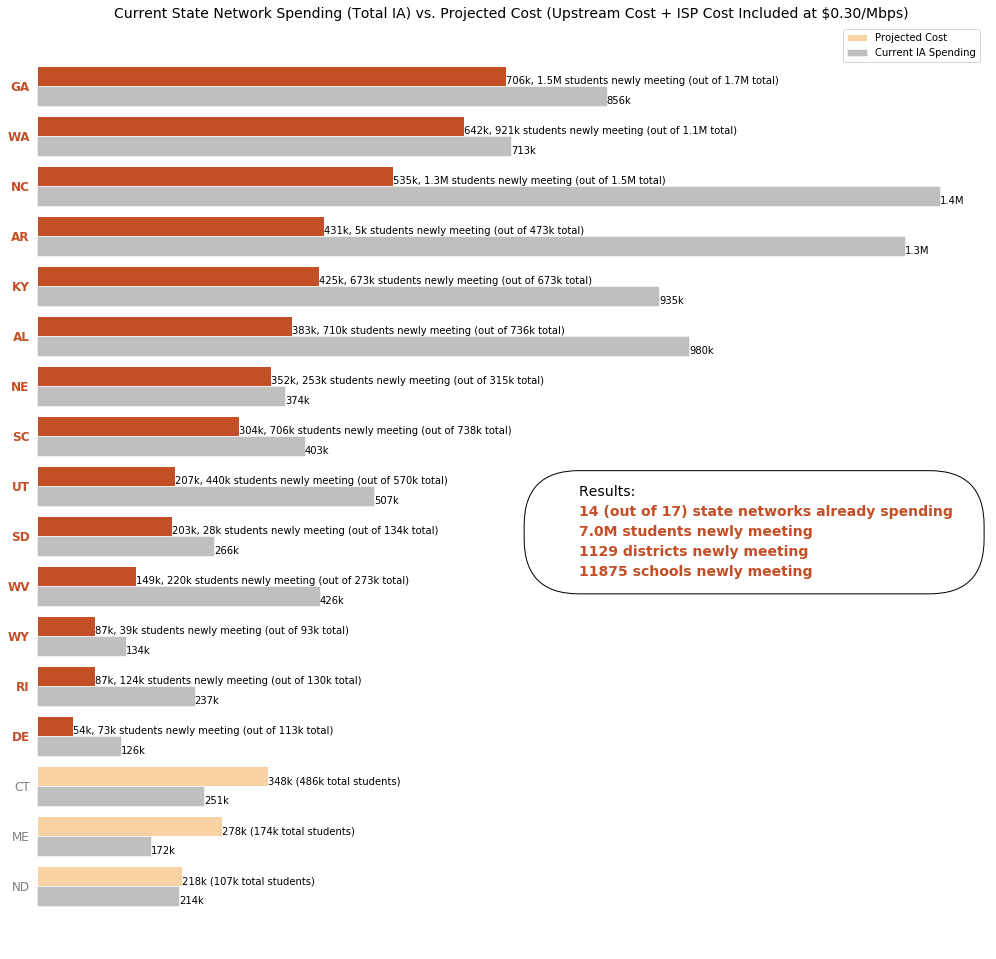

In [45]:
# inputs
sort_col = 'total_projected_cost3'
compare_col = 'ia_monthly_cost_total'
already_spending_col = 'already_spending_3'
color_code = '03'
df_input = df_agg.sort_values([already_spending_col, sort_col])

# customize colors
bar_colors = {'03': '#c44f27', '49': '#006b6e', '74':'#68ab44'}
colors = []
for proj_cost, orig_cost in zip(df_input[sort_col], df_input[compare_col]): 
    if orig_cost >= proj_cost:
        # change bar color
        colors.append(bar_colors[color_code])
    else:
        colors.append('#f9d2a3')

fig, ax = plt.subplots(figsize=(17, 17))

bar_size = 0.4

y_locs = np.arange(df_input.shape[0])

rects1 = ax.barh(y_locs, df_input[sort_col], align='edge', edgecolor='white', height=bar_size, color=colors, label="Projected Cost")
rects2 = ax.barh(y_locs - bar_size, df_input[compare_col], edgecolor='white', align='edge', height=bar_size, color='grey', label="Current IA Spending", alpha=0.5)

# pretty plot
plt.yticks(y_locs, df_input.state_code);
for ticklabel, tickcolor in zip(plt.gca().get_yticklabels(), colors):
    ticklabel.set_color('grey')
    ticklabel.set_fontsize(12) 
    if tickcolor == bar_colors[color_code]:
        ticklabel.set_color(tickcolor)
        ticklabel.set_fontweight('bold')

    
# states already spending
states_already_spending = df_input[df_input[already_spending_col] == True]['state_code'].unique()

# total students newly meeting
total_students_newly_meeting_pp = '{:,.1f}M'.format(df_input[df_input.state_code.isin(states_already_spending)]['num_students_newly_meeting_extrap'].sum()/1000000) 

# total district newly meeting
total_districts_newly_meeting_pp = round(int(df_input[df_input.state_code.isin(states_already_spending)]['num_districts_newly_meeting_extrap'].sum()))

# total schools newly meeting
total_schools_newly_meeting_pp = round(int(df_input[df_input.state_code.isin(states_already_spending)]['num_schools_newly_meeting_extrap'].sum()))


        
        
plt.title("Current State Network Spending (Total IA) vs. Projected Cost (Upstream Cost + ISP Cost Included at $0.30/Mbps)", fontsize=14)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=True, labelbottom=False)
plt.box(None)
plt.legend(loc='upper right');

# add labels
for y0, y1, v0, v1, state, label_proj, label_sn, label_students_nm, label_students in zip(y_locs, y_locs - bar_size, 
                                            df_input[sort_col], df_input[compare_col],  
                                                df_input.state_code, 
                                                df_input[sort_col+'_pp'], df_input[compare_col+'_pp'],
                                                df_input['num_students_newly_meeting_extrap_pp'],
                                                df_input['num_students_pp']             
                                               ):
    if state in states_already_spending:
        plt.text(v0, y0, label_proj + ", " + label_students_nm + " students newly meeting (out of " + \
                 label_students + " total)" , ha='left', va='bottom')
        plt.text(v1, y1, label_sn, ha='left', va='bottom')
    else:
        plt.text(v0, y0, label_proj + " (" + label_students + " total students)" , ha='left', va='bottom')
        plt.text(v1, y1, label_sn, ha='left', va='bottom')
    

# add conclusion - box
plt.text(0.6*max(df_input[compare_col]), 7.8, "Results: ", fontsize=14)
plt.text(0.6*max(df_input[compare_col]), 7.4, str(df_input[already_spending_col].sum()) + " (out of " + str(df_input.shape[0]) + ") state networks already spending" , fontsize=14, fontweight='bold', color=bar_colors[color_code])
         
plt.text(0.6*max(df_input[compare_col]), 7., total_students_newly_meeting_pp + " students newly meeting                        ", fontsize=14, fontweight='bold', color=bar_colors[color_code], bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=3.9'));

plt.text(0.6*max(df_input[compare_col]), 6.6, str(total_districts_newly_meeting_pp) + " districts newly meeting", fontsize=14, fontweight='bold', color=bar_colors[color_code])

plt.text(0.6*max(df_input[compare_col]), 6.2, str(total_schools_newly_meeting_pp) + " schools newly meeting", fontsize=14, fontweight='bold', color=bar_colors[color_code]);



# save figure
plt.savefig("projected_cost_with_isp_cpm3_092619_oversub.png", bbox_inches='tight')



In [46]:
# converting to a .py file
!jupyter nbconvert --to script state_networks_projections_updated_090319.ipynb

[NbConvertApp] Converting notebook state_networks_projections_updated_090319.ipynb to script
[NbConvertApp] Writing 21883 bytes to state_networks_projections_updated_090319.py
